This notebook allows collecting results across multiple pipeline runs. Concatenating across sessions and bin sizes. 
It takes CSVs, then determines the most recent one from the filename. 

There are two major sets of decoded epochs - Laps and Ripples/Replays
There are two sets of marginals for the decoded epochs - the "by epoch" and "by time bin" marginals.
The "by time bin" epochs are a larger granulation, with each epoch consisting of one or more time bin.


```python

# 2024-01-23 - 
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-fet11-01_12-58-54_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-03_12-3-25_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-02_17-46-44_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-02_19-28-0_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-10_12-58-3_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-10_12-25-50_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-09_16-40-54_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-09_22-24-40_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-12_16-53-46_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-09_17-29-30_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-08_14-26-15_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-09_1-22-43_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-07_16-40-19_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-08_21-16-25_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-12_15-55-31_time_bin_size_sweep_results.h5



# found_session_export_paths = [Path(v).resolve() for v in  ["C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0420PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0420PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0645PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0645PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# ]]
```

In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3
import sys
from copy import deepcopy
from typing import List, Dict, Tuple, Optional, Union, Callable
import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

# matplotlib.use('Qt5Agg')
%matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
import seaborn as sns

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import find_csv_files, find_HDF5_files, find_most_recent_files, process_csv_file
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms

debug_print: bool = False

Automatic pdb calling has been turned OFF


# Definitions

In [2]:
## Load across session t_delta CSV, which contains the t_delta for each session:
t_delta_csv_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\2024-01-18_GL_t_split_df.csv').resolve() # Apogee
# t_delta_csv_path = Path('/home/halechr/cloud/turbo/Data/Output/collected_outputs/2024-01-18_GL_t_split_df.csv').resolve() # GL

# collected_outputs_directory = '/home/halechr/FastData/collected_outputs/'
# collected_outputs_directory = r'C:\Users\pho\Desktop\collected_outputs'
collected_outputs_directory = r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs' # APOGEE
# collected_outputs_directory = '/home/halechr/cloud/turbo/Data/Output/collected_outputs' # GL

## Find the files:
csv_files = find_csv_files(collected_outputs_directory)
h5_files = find_HDF5_files(collected_outputs_directory)

csv_sessions = find_most_recent_files(found_session_export_paths=csv_files)
h5_sessions = find_most_recent_files(found_session_export_paths=h5_files)


## The CSV containing the session delta time:
t_delta_df = pd.read_csv(t_delta_csv_path, index_col=0) # Assuming that your CSV file has an index column
# adds `delta_aligned_t_start`, `delta_aligned_t_end` columns
t_delta_df['delta_aligned_t_start'] = t_delta_df['t_start'] - t_delta_df['t_delta']
t_delta_df['delta_aligned_t_end'] = t_delta_df['t_end'] - t_delta_df['t_delta']

# computes `earliest_delta_aligned_t_start`, latest_delta_aligned_t_end
earliest_delta_aligned_t_start: float = np.nanmin(t_delta_df['delta_aligned_t_start'])
latest_delta_aligned_t_end: float = np.nanmax(t_delta_df['delta_aligned_t_end'])
print(f'earliest_delta_aligned_t_start: {earliest_delta_aligned_t_start}, latest_delta_aligned_t_end: {latest_delta_aligned_t_end}')
t_delta_dict = t_delta_df.to_dict(orient='index')
# t_delta_df

# csv_sessions
# Extract each of the separate files from the sessions:
    
final_sessions = {}
final_sessions_loaded_laps_dict = {}
final_sessions_loaded_ripple_dict = {}
final_sessions_loaded_laps_time_bin_dict = {}
final_sessions_loaded_ripple_time_bin_dict = {}

for session_str, session_dict in csv_sessions.items():
    # try:
        final_sessions[session_str] = {}
        for file_type, (an_decoding_time_bin_size_str, a_path, an_export_datetime) in session_dict.items():
            final_sessions[session_str][file_type] = a_path
            
        session_name: str = str(session_str)  # Extract session name from the filename
        if debug_print:
            print(f'processing session_name: {session_name}')
        curr_session_t_delta: Optional[float] = t_delta_dict.get(session_name, {}).get('t_delta', None)
        if curr_session_t_delta is None:
            print(f'WARN: curr_session_t_split is None for session_str = "{session_str}"')

        # finds each of the four exports:
        try:
            laps_file = final_sessions[session_str]['laps_marginals_df']
            final_sessions_loaded_laps_dict[session_str] = process_csv_file(laps_file, session_name, curr_session_t_delta, 'lap_start_t')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   
                    
        try:
            ripple_file = final_sessions[session_str]['ripple_marginals_df']
            final_sessions_loaded_ripple_dict[session_str] = process_csv_file(ripple_file, session_name, curr_session_t_delta, 'ripple_start_t')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   
            

        try:
            laps_time_bin_file = final_sessions[session_str]['laps_time_bin_marginals_df']
            final_sessions_loaded_laps_time_bin_dict[session_str] = process_csv_file(laps_time_bin_file, session_name, curr_session_t_delta, 't_bin_center')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   


        try:
            ripple_time_bin_file = final_sessions[session_str]['ripple_time_bin_marginals_df']
            final_sessions_loaded_ripple_time_bin_dict[session_str] = process_csv_file(ripple_time_bin_file, session_name, curr_session_t_delta, 't_bin_center')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   


## Build across_sessions join dataframes:
all_sessions_laps_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_laps_dict.values()), axis='index', ignore_index=True)
all_sessions_ripple_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_ripple_dict.values()), axis='index', ignore_index=True)

# *_time_bin marginals:
all_sessions_laps_time_bin_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_laps_time_bin_dict.values()), axis='index', ignore_index=True)
all_sessions_ripple_time_bin_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_ripple_time_bin_dict.values()), axis='index', ignore_index=True)

# Filter rows based on column: 'time_bin_size'
all_sessions_laps_df = all_sessions_laps_df[all_sessions_laps_df['time_bin_size'].notna()]
all_sessions_ripple_df = all_sessions_ripple_df[all_sessions_ripple_df['time_bin_size'].notna()]
all_sessions_laps_time_bin_df = all_sessions_laps_time_bin_df[all_sessions_laps_time_bin_df['time_bin_size'].notna()]
all_sessions_ripple_time_bin_df = all_sessions_ripple_time_bin_df[all_sessions_ripple_time_bin_df['time_bin_size'].notna()]

all_sessions_laps_time_bin_df

ERR: Could not parse filename: "2024-01-18_GL_t_split_df"
earliest_delta_aligned_t_start: -2057.2259484970764, latest_delta_aligned_t_end: 1661.8560019930592


,Unnamed: 0,P_LR,P_RL,P_Long,P_Short,epoch_idx,t_bin_center,session_name,delta_aligned_start_t,time_bin_size
19018,0,0.491114,0.508886,3.876855e-01,0.612315,0,6.907083,kdiba_vvp01_one_2006-4-10_12-25-50,-876.990049,0.03
19019,1,0.491114,0.508886,3.876855e-01,0.612315,0,6.937083,kdiba_vvp01_one_2006-4-10_12-25-50,-876.960049,0.03
19020,2,0.491114,0.508886,3.876855e-01,0.612315,0,6.967083,kdiba_vvp01_one_2006-4-10_12-25-50,-876.930049,0.03
19021,3,0.491114,0.508886,3.876855e-01,0.612315,0,6.997083,kdiba_vvp01_one_2006-4-10_12-25-50,-876.900049,0.03
19022,4,0.491114,0.508886,3.876855e-01,0.612315,0,7.027083,kdiba_vvp01_one_2006-4-10_12-25-50,-876.870049,0.03
...,...,...,...,...,...,...,...,...,...,...
627816,57452,0.993650,0.006350,8.458879e-01,0.154112,79,2068.387436,kdiba_gor01_one_2006-6-08_14-26-15,856.829356,0.10
627817,57453,0.875051,0.124949,6.168876e-07,0.999999,79,2068.487436,kdiba_gor01_one_2006-6-08_14-26-15,856.929356,0.10
627818,57454,0.703433,0.296567,2.924253e-01,0.707575,79,2068.587436,kdiba_gor01_one_2006-6-08_14-26-15,857.029356,0.10
627819,57455,0.928085,0.071915,8.841508e-01,0.115849,79,2068.687436,kdiba_gor01_one_2006-6-08_14-26-15,857.129356,0.10


In [3]:
# final_sessions
# {'kdiba_gor01_one_2006-6-08_14-26-15': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-17_0540PM-kdiba_gor01_one_2006-6-08_14-26-15-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-17_0540PM-kdiba_gor01_one_2006-6-08_14-26-15-(laps_marginals_df).csv')},
#  'kdiba_gor01_one_2006-6-09_1-22-43': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0838PM-kdiba_gor01_one_2006-6-09_1-22-43-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0838PM-kdiba_gor01_one_2006-6-09_1-22-43-(laps_marginals_df).csv')},
#  'kdiba_pin01_one_fet11-01_12-58-54': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv')}}


# Save out the four dataframes to CSVs:
final_dfs_dict = {"AcrossSession_Laps_per-Epoch": all_sessions_laps_df, "AcrossSession_Ripple_per-Epoch": all_sessions_ripple_df,
				   "AcrossSession_Laps_per-TimeBin": all_sessions_laps_time_bin_df, "AcrossSession_Ripple_per-TimeBin": all_sessions_ripple_time_bin_df}

final_output_path = Path("../output/").resolve()
TODAY_DAY_DATE: str = f"2024-01-29"

final_csv_export_paths = {}
for a_name, a_final_df in final_dfs_dict.items():
	# save out one final DF to csv.
	out_csv_filename: str = f"{TODAY_DAY_DATE}_{a_name}.csv"
	a_final_csv_export_path = final_output_path.joinpath(out_csv_filename).resolve()
	a_final_df.to_csv(a_final_csv_export_path) # save to CSV.
	final_csv_export_paths[a_name] = a_final_csv_export_path
	

final_csv_export_paths


{'AcrossSession_Laps_per-Epoch': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-29_AcrossSession_Laps_per-Epoch.csv'),
 'AcrossSession_Ripple_per-Epoch': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-29_AcrossSession_Ripple_per-Epoch.csv'),
 'AcrossSession_Laps_per-TimeBin': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-29_AcrossSession_Laps_per-TimeBin.csv'),
 'AcrossSession_Ripple_per-TimeBin': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-29_AcrossSession_Ripple_per-TimeBin.csv')}

# Plotting functions

In [38]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														   enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   save_figures=True, figure_save_extension=['.html','.png'])
fig_laps, fig_ripples = all_session_figures[0]

# Show figures for all sessions
# for fig_laps, fig_ripples in all_session_figures:
# # Create two shapes for the pre/post-delta periods. Requires earliest_delta_aligned_t_start, earliest_delta_aligned_t_start
# t_split: float = 0.0
# _laps_extras_output_dict = PlottingHelpers.helper_plotly_add_long_short_epoch_indicator_regions(fig_laps, t_split=t_split, t_start=earliest_delta_aligned_t_start, t_end=latest_delta_aligned_t_end)
# _ripple_extras_output_dict = PlottingHelpers.helper_plotly_add_long_short_epoch_indicator_regions(fig_ripples, t_split=t_split, t_start=earliest_delta_aligned_t_start, t_end=latest_delta_aligned_t_end)


# fig_laps.update_layout(shapes=[blue_shape, red_shape], xaxis=dict(range=[earliest_delta_aligned_t_start, latest_delta_aligned_t_end]), yaxis=dict(range=[0.0, 1.0]))
# fig_ripples.update_layout(shapes=[blue_shape, red_shape], xaxis=dict(range=[earliest_delta_aligned_t_start, latest_delta_aligned_t_end]), yaxis=dict(range=[0.0, 1.0]))

fig_laps.show()
fig_ripples.show()
fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")

plot_across_sessions_results(directory: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs)
	figures_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\figures
filtering data_results_df to enabled_time_bin_sizes: [0.03, 0.1]...
num_unique_sessions: 13, num_unique_time_bins: 2
WARN: build_only == True so fig.update_layout(...) will not be called.
filtering data_results_df to enabled_time_bin_sizes: [0.03, 0.1]...
num_unique_sessions: 14, num_unique_time_bins: 2
WARN: build_only == True so fig.update_layout(...) will not be called.
	saving figures...
	saving "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\figures\13-Sessions_laps_marginal.html"...
	saving "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\figures\14-Sessions_ripples_marginal.html"...
	saving "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\figures\13-Sessions_laps_marginal.png"...
	saving "C:\Users\pho\repos\Spike3DWorkEnv\Spi

In [ ]:
print(fig_laps)


In [ ]:
fig_laps.layout 

# Layout({
#     'legend': {'itemsizing': 'constant', 'title': {'text': 'session_name'}, 'tracegroupgap': 0},
#     'template': '...',
#     'title': {'text': 'Laps - 13 Sessions'},
#     'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'delta_aligned_start_t'}},
#     'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'range': [0.0, 1.0], 'title': {'text': 'P_Long'}}
# })

fig_laps

In [ ]:
fig_laps.layout.xaxis
fig_laps.update_yaxes(range = [0,1])
fig_laps.layout.xaxis


In [ ]:
active_plot_fn = plot_across_sessions_scatter_results
# active_plot_fn = plot_across_sessions_results_with_histogram_gpt3
# active_plot_fn = plot_across_sessions_results_with_histogram_new
all_time_bin_session_figures = active_plot_fn(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df, save_figures=False)
all_time_bin_session_figures

for fig_time_bin_laps, fig_time_bin_ripples in all_time_bin_session_figures:
    fig_time_bin_laps.show()
    fig_time_bin_ripples.show()
    # fig_laps.write_html("../output/2024-01-18_AcrossSession_fig_laps.html")
    # fig_ripples.write_html("../output/2024-01-18_AcrossSession_fig_ripples.html")
    fig_time_bin_laps.write_html("../output/2024-01-23_AcrossSession_fig_time_bin_laps.html")
    fig_time_bin_ripples.write_html("../output/2024-01-23_AcrossSession_fig_time_bin_ripples.html")


In [ ]:
all_time_bin_session_figures[0].show()

In [ ]:
all_sessions_laps_df

In [ ]:
# fig_laps.for_each_xaxis
# fig_laps.for_each_trace(
# fig_laps.to_plotly_json()
# fig_laps.to_dict()
len(fig_laps.data)



In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import complete_plotly_figure


# data_results_df: pd.DataFrame = deepcopy(all_sessions_laps_df) # all_sessions_laps_time_bin_df
# histogram_bins = 'auto'
histogram_bins: int = 25

new_laps_fig = complete_plotly_figure(data_results_df=deepcopy(all_sessions_laps_df), out_scatter_fig=fig_laps, histogram_bins=histogram_bins)
new_laps_fig

In [ ]:
new_ripple_fig = complete_plotly_figure(data_results_df=deepcopy(all_sessions_ripple_df), out_scatter_fig=fig_ripples, histogram_bins=histogram_bins)
new_ripple_fig

In [ ]:
fig.data

In [ ]:
data_results_df

In [ ]:
data_results_df: pd.DataFrame = deepcopy(all_sessions_laps_df) # all_sessions_laps_time_bin_df
# histogram_bins = 'auto'
histogram_bins = 25

# get the pre-delta epochs
pre_delta_df: pd.DataFrame = data_results_df[data_results_df['delta_aligned_start_t'] <= 0]
post_delta_df: pd.DataFrame = data_results_df[data_results_df['delta_aligned_start_t'] > 0]

X_all = data_results_df['delta_aligned_start_t'].to_numpy()
Y_all = data_results_df['P_Long'].to_numpy()

X_pre_delta = pre_delta_df['delta_aligned_start_t'].to_numpy()
X_post_delta = post_delta_df['delta_aligned_start_t'].to_numpy()

Y_pre_delta = pre_delta_df['P_Long'].to_numpy()
Y_post_delta = post_delta_df['P_Long'].to_numpy()

# fig = px.histogram(pre_delta_df, y="P_Long", color="session_name", hover_name="session_name", title="Hover over the rug plot!")
# fig = px.histogram(pre_delta_df, y="P_Long", color="time_bin_size", opacity=0.5, hover_name="time_bin_size", title="Hover over the rug plot!", range_y=[0.0, 1.0], nbins=histogram_bins)
pre_delta_fig = px.histogram(pre_delta_df, y="P_Long", color="time_bin_size", opacity=0.5, hover_name="time_bin_size", title="Pre-delta", range_y=[0.0, 1.0], nbins=histogram_bins)
post_delta_fig = px.histogram(post_delta_df, y="P_Long", color="time_bin_size", opacity=0.5, hover_name="time_bin_size", title="Post-delta", range_y=[0.0, 1.0], nbins=histogram_bins)

pre_delta_fig.show()
post_delta_fig.show()

In [ ]:
post_delta_fig.data

C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:453: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:453: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



MatplotlibRenderPlots({'name': 'plot_histograms', 'context': None, 'figures': [<Figure size 640x480 with 2 Axes>], 'axes': {'epochs_pre_delta': <Axes: label='epochs_pre_delta', title={'center': 'Ripples|All Sessions|75 ms - pre-$\\Delta$ time bins'}>, 'epochs_post_delta': <Axes: label='epochs_post_delta', title={'center': 'Ripples|All Sessions|75 ms - post-$\\Delta$ time bins'}>}})

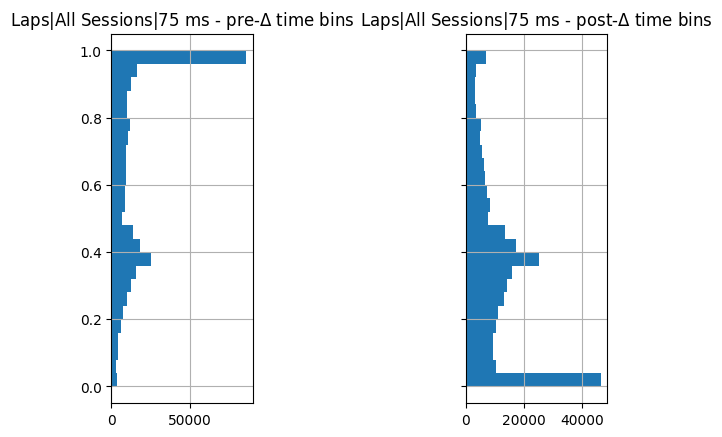

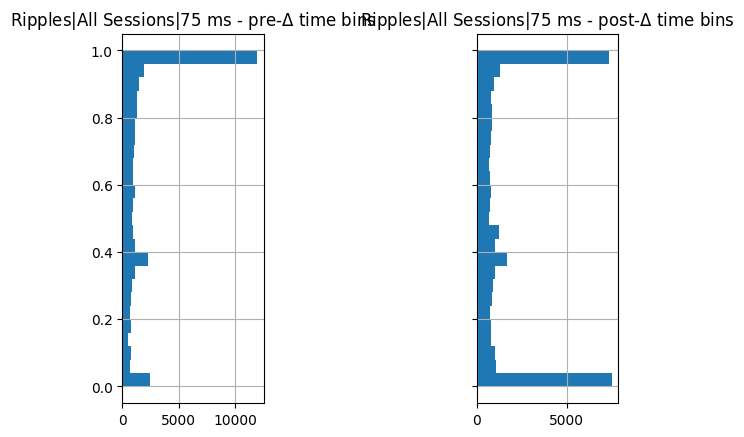

In [32]:

# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:
plot_histograms(all_sessions_laps_time_bin_df, 'Laps', 'All Sessions', "75 ms")
plot_histograms(all_sessions_ripple_time_bin_df, 'Ripples', 'All Sessions', "75 ms")

C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:505: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



MatplotlibRenderPlots({'name': 'plot_stacked_histograms', 'context': None, 'figures': [<Figure size 1200x200 with 2 Axes>], 'axes': {'epochs_pre_delta': <Axes: label='epochs_pre_delta', title={'center': 'pre-$\\Delta$ time bins'}>, 'epochs_post_delta': <Axes: label='epochs_post_delta', title={'center': 'post-$\\Delta$ time bins'}>}})

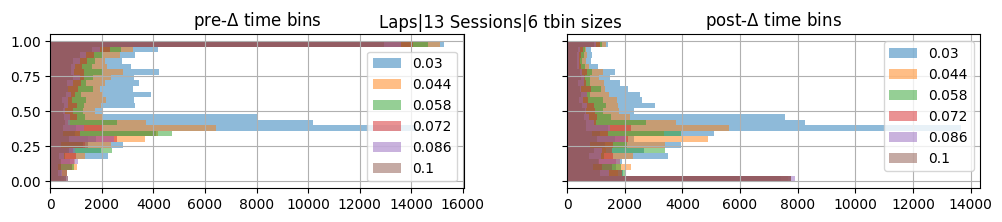

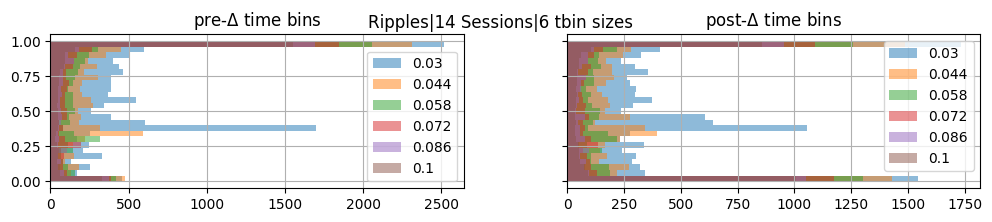

In [33]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:
num_unique_sessions: int = all_sessions_laps_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_laps_time_bin_df.time_bin_size.nunique(dropna=True)
plot_stacked_histograms(all_sessions_laps_time_bin_df, 'Laps', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes")

num_unique_sessions: int = all_sessions_ripple_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_ripple_time_bin_df.time_bin_size.nunique(dropna=True)
plot_stacked_histograms(all_sessions_ripple_time_bin_df, 'Ripples', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes")

In [ ]:
time_bin_sizes: int = all_sessions_laps_time_bin_df['time_bin_size'].unique()
time_bin_sizes

In [ ]:
def plot_across_sessions_scatter_results(directory, concatenated_laps_df, concatenated_ripple_df, save_figures=False, figure_save_extension='.png'):
    """ takes the directory containing the .csv pairs that were exported by `export_marginals_df_csv`
    Produces and then saves figures out the the f'{directory}/figures/' subfolder

    Unknowingly captured: session_name
    
    """
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    if not isinstance(directory, Path):
        directory = Path(directory).resolve()
    assert directory.exists()
    print(f'plot_across_sessions_results(directory: {directory})')
    if save_figures:
        # Create a 'figures' subfolder if it doesn't exist
        figures_folder = Path(directory, 'figures')
        figures_folder.mkdir(parents=False, exist_ok=True)
        assert figures_folder.exists()
        print(f'\tfigures_folder: {figures_folder}')
    
    # Create an empty list to store the figures
    all_figures = []

    ## delta_t aligned:
    # Create a bubble chart for laps
    laps_num_unique_sessions: int = concatenated_laps_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
    laps_num_unique_time_bins: int = concatenated_laps_df.time_bin_size.nunique(dropna=True)
    laps_title_string_suffix: str = f'{laps_num_unique_sessions} Sessions'
    fig_laps = go.Figure(px.scatter(concatenated_laps_df, x='delta_aligned_start_t', y='P_Long', title=f"Laps - {laps_title_string_suffix}", color='session_name', size='time_bin_size'), layout_yaxis_range=[0.0, 1.0])

    # Create a bubble chart for ripples
    ripple_num_unique_sessions: int = concatenated_ripple_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
    ripple_num_unique_time_bins: int = concatenated_ripple_df.time_bin_size.nunique(dropna=True)
    ripple_title_string_suffix: str = f'{ripple_num_unique_sessions} Sessions'
    fig_ripples = go.Figure(px.scatter(concatenated_ripple_df, x='delta_aligned_start_t', y='P_Long', title=f"Ripples - {ripple_title_string_suffix}", color='session_name', size='time_bin_size'), layout_yaxis_range=[0.0, 1.0])

    if save_figures:
        # Save the figures to the 'figures' subfolder
        print(f'\tsaving figures...')
        fig_laps_name = Path(figures_folder, f"{laps_title_string_suffix.replace(' ', '-')}_laps_marginal{figure_save_extension}").resolve()
        print(f'\tsaving "{fig_laps_name}"...')
        fig_laps.write_image(fig_laps_name)
        fig_ripple_name = Path(figures_folder, f"{ripple_title_string_suffix.replace(' ', '-')}_ripples_marginal{figure_save_extension}").resolve()
        print(f'\tsaving "{fig_ripple_name}"...')
        fig_ripples.write_image(fig_ripple_name)
    
    # Append both figures to the list
    all_figures.append((fig_laps, fig_ripples))
    
    return all_figures

In [ ]:
all_sessions_laps_time_bin_df.hist(column='P_Long')
plt.show()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import plot_all_epoch_bins_marginal_predictions
from attrs import define, field, Factory
from neuropy.utils.result_context import IdentifyingContext

@define(slots=False)
class TwoCSV:
	""" simple class wrapper to emulate the object that holds the other dfs """
	laps_all_epoch_bins_marginals_df = field()
	ripple_all_epoch_bins_marginals_df = field()

save_figure = True
def _perform_write_to_file_callback(final_context, fig):
	print(f'final_context: {final_context}')
	# if save_figure:
	# 	fig.save_fig(
	# 	# return owning_pipeline_reference.output_figure(final_context, fig)
	# else:
	# 	pass # do nothing, don't save
	
# all_sessions_laps_time_bin_df

collector = plot_all_epoch_bins_marginal_predictions(TwoCSV(laps_all_epoch_bins_marginals_df=all_sessions_laps_df, ripple_all_epoch_bins_marginals_df=all_sessions_ripple_df), t_start=None, t_split=0.0, t_end=None,
													active_context=IdentifyingContext(), perform_write_to_file_callback=_perform_write_to_file_callback)
collector



In [ ]:
result = tuple(collector.figures)


In [ ]:
result[0].show()

# HDF5 files

In [ ]:
from neuropy.utils.result_context import IdentifyingContext
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import H5FileAggregator

h5_sessions = find_most_recent_files(found_session_export_paths=h5_files)
h5_sessions

final_sessions = {}
time_bin_size_sweep_results_files = {}

# final_sessions_loaded_laps_dict = {}
# final_sessions_loaded_ripple_dict = {}
# final_sessions_loaded_laps_time_bin_dict = {}
# final_sessions_loaded_ripple_time_bin_dict = {}

for session_str, session_dict in h5_sessions.items():
    final_sessions[session_str] = {}
    for file_type, (a_path, an_export_datetime) in session_dict.items():
        final_sessions[session_str][file_type] = a_path
        
    session_name: str = str(session_str)  # Extract session name from the filename
    if debug_print:
        print(f'processing session_name: {session_name}')
    curr_session_t_delta: Optional[float] = t_delta_dict.get(session_name, {}).get('t_delta', None)
    if curr_session_t_delta is None:
        print(f'WARN: curr_session_t_split is None for session_str = "{session_str}"')

    # finds each of the four exports:
    time_bin_size_sweep_results_file = final_sessions[session_str]['time_bin_size_sweep_results']
    time_bin_size_sweep_results_files[session_str] = Path(time_bin_size_sweep_results_file).resolve()
    # ripple_file = final_sessions[session_str]['ripple_marginals_df']
    # laps_time_bin_file = final_sessions[session_str]['laps_time_bin_marginals_df']
    # ripple_time_bin_file = final_sessions[session_str]['ripple_time_bin_marginals_df']
    


session_identifiers = [
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'), # prev completed
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'), # prev completed
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31'), # prev completed
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19'), # prev completed
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44'), # prev completed
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54'), # prev completed
]

# Keys are like: "/kdiba|gor01|two|2006-6-12_16-53-46"
included_h5_paths = list(time_bin_size_sweep_results_files.values())
session_group_keys: List[str] = [("/" + a_ctxt.get_description(separator="|", include_property_names=False)) for a_ctxt in session_identifiers] # 'kdiba/gor01/one/2006-6-08_14-26-15'
laps_decoding_accuracy_results_table_keys = [f"{session_group_key}/laps_decoding_accuracy_results/table" for session_group_key in session_group_keys]
a_loader = H5FileAggregator.init_from_file_lists(file_list=included_h5_paths, table_key_list=laps_decoding_accuracy_results_table_keys)
_out_table = a_loader.load_and_consolidate()
_out_table